In [1]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logit
from abc import ABC, abstractmethod
from matplotlib import cm

In [2]:
np.random.seed(1)

In [3]:
DIVERGENCE_VALUE = 10

In [4]:
class AbstractLoss(ABC):
 
    def __init__(self, p1lim, p2lim, granularity = 1000):
        # Storing parameters
        self.granularity = granularity
        # Preprocess data
        self.p1 = np.linspace(p1lim[0], p1lim[1], granularity)
        self.p2 = np.linspace(p2lim[0], p2lim[1], granularity)
        self.p1p1, self.p2p2 = np.meshgrid(self.p1, self.p2)
        
        super().__init__()
        
    @abstractmethod
    def _calculate_gradient(self, x, y, current_params):
        pass
    
    @abstractmethod
    def _calculate_hessian(self, x, y, current_params):
        pass
    
    @abstractmethod
    def produce_dataset(self):
        pass
    
    @abstractmethod
    # Grid approximation if params = None, otherwise, calculate for a specific combination of parameters
    def calculate_loss_2D(self, params = None):
        pass
    
    @abstractmethod
    def _plot_model(self, *args):
        pass
    
    def _plot_gradient_descent_2D(self, fig, ax, caption, values):
        self._plot_loss_2D(fig, ax) 
        ax.plot(values[:, 0], 
                values[:, 1], 
                marker = 'x', 
                linestyle = '-', 
                color = 'r', 
                markerfacecolor = 'r', 
                markeredgecolor = 'r') 
        ax.set_title(caption)
        
    def _plot_gradient_descent_1D(self, fig, ax, caption, axis, index, values):
        self._plot_loss_1D(fig, ax, axis, index)
        caption = 'Fixed parameter ' + ax.get_title() + '\n' + caption
        
        if axis == 0:
            other = self.p2[index]
        else:
            other = self.p2[index]
            
        ax.plot(values[:], 
                [self.calculate_loss_2D([v, other]) for v in values], 
                marker = 'x', 
                linestyle = '-', 
                color = 'r', 
                markerfacecolor = 'r', 
                markeredgecolor = 'r')
        ax.set_title(caption)
    
    def _plot_loss_2D(self, fig, ax):
        ax.contourf(self.p1, self.p2, self.l, cmap = cm.coolwarm, alpha = 0.5)
        ax.set_xlabel(self.param_names[0])
        ax.set_ylabel(self.param_names[1])
    
    def _plot_loss_1D(self, fig, ax, axis, index):
        if axis == 0:
            self.l1d = self.l[index, :]
            x = self.p1
            param = self.param_names[0]
            other = self.param_names[1] + ' = ' + str(self.p2[index])
        elif axis == 1:
            self.l1d = self.l[:, index]
            x = self.p2
            param = self.param_names[1]
            other = self.param_names[0] + ' = ' + str(self.p1[index])
        else:
            raise ValueError('Incorrect axis value')
            
        ax.plot(x, self.l1d)
        ax.set_xlabel(param)
        ax.set_ylabel('loss')
        ax.set_title(other)
        
    def gridsearch_loss_2D(self):
        fig, ax = plt.subplots()
        self._plot_loss_2D(fig, ax)
        
        minimum = np.unravel_index(np.argmin(self.l), self.l.shape)
        print('Gridsearch minimum:')
        print(self.param_names[0] + ': ' + str(self.p1p1[minimum]))
        print(self.param_names[1] + ': ' + str(self.p2p2[minimum]))
        print('Loss function value: ' + str(self.l[minimum]))
        ax.plot(self.p1p1[minimum], 
                self.p2p2[minimum], 
                markerfacecolor = 'red', 
                markeredgecolor = 'red', 
                marker = 'x', 
                markersize = 5)
        
        self._plot_model(self.p1p1[minimum], self.p2p2[minimum])
        
    def gridsearch_loss_1D(self, axis, index):
        fig, ax = plt.subplots()
        self._plot_loss_1D(fig, ax, axis, index)
        
        # The incorrect index value exception is already raised in the plot_loss_1D function
        if axis == 0:
            x = self.p1
            name = self.param_names[0]
        else:
            x = self.p2
            name = self.param_names[1]
            
        minimum = np.argmin(self.l1d)
        print('Gridsearch minimum:')
        print(name + ': ' + str(x[minimum]))
        print('Loss function value: ' + str(self.l1d[minimum]))
        ax.plot(x[minimum], 
                self.l1d[minimum], 
                markerfacecolor = 'red',
                markeredgecolor = 'red', 
                marker = 'o', 
                markersize = 5)
        
    # Spected values for method:
    # 'steepest' - steepest gradient descent
    # 'annealing' - steepest gradient descent with learning rate annealing
    # 'newton' - Newton's optimisation method based on the Hessian matrix (ignores the learning rate parameter)
    def steepest_gradient_descend_2D(self, 
                                     initial_p1_index,
                                     initial_p2_index,
                                     learning_rates = [0.01], 
                                     stop_threshold = 0.0001,
                                     method = 'steepest'):
        
        if not type(learning_rates) == list:
            raise ValueError('Learning rates have to be provided in a list')
            
        if method == 'steepest':
            caption_0 = 'Steepest gradient descent\n'
        elif method == 'annealing':
            caption_0 = 'Steepest gradient descent with annealing\n'
        elif method == 'newton':
            caption_0 = 'Newton\'s optimisation method\n'
        else:
            raise ValueError('Incorrect gradient descent method value')
            
        rows = int((len(learning_rates) + 1) / 2)
        fig, ax = plt.subplots(rows, 2)
        fig.set_figwidth(13)
        fig.set_figheight(5 * rows)
        r = 0
        c = 0
        
        for learning_rate in learning_rates:
            params_history = [[initial_p1_index + stop_threshold, initial_p2_index + stop_threshold]]
            current_params = [initial_p1_index, initial_p2_index]
            learning_rate_0 = learning_rate # For annealing

            while np.sum(np.abs(np.array(current_params) - np.array(params_history[-1]))) > stop_threshold and \
                  np.all(np.array(current_params) - np.array(params_history[-1]) < DIVERGENCE_VALUE):
                params_history.append(current_params)
                
                gradient = np.array(self._calculate_gradient(self.x, self.y, current_params))
                if method == 'steepest' or method == 'annealing':
                    if method == 'annealing':
                        learning_rate = learning_rate_0 / float(len(params_history))
                    step = learning_rate * gradient
                elif method == 'newton':
                    hessian_inv = np.linalg.inv(self._calculate_hessian(self.x, self.y, current_params))
                    step = np.matmul(hessian_inv, gradient)  
                    
                current_params = (np.array(current_params) - step).tolist()

            caption = caption_0 + 'Learning rate = ' + str(learning_rate) 
            caption = caption + ' (' +  str(len(params_history)) + ' iterations)\n'
            if np.any(np.array(current_params) - np.array(params_history[-1]) >= DIVERGENCE_VALUE):
                caption = caption + '   Algorithm interrupted - divergence detected\n'
            caption = caption + self.param_names[0] + ': ' + str(current_params[0]) + '\n'
            caption = caption + self.param_names[1] + ': ' + str(current_params[1]) + '\n'
            caption = caption + 'Loss function value: ' + str(self.calculate_loss_2D(current_params))
            
            if rows == 1:
                ax_i = ax[c]
            else:
                ax_i = ax[r][c]
            self._plot_gradient_descent_2D(fig, ax_i, caption, np.array(params_history[1:]))
            c = c + 1
            if c > 1:
                c = 0
                r = r + 1               
        plt.tight_layout()
        if c == 1:
            if rows == 1:
                ax[c].axis('off')
            else:
                ax[r][c].axis('off')
        
    def steepest_gradient_descend_1D(self, 
                                     axis, 
                                     index, 
                                     initial_p_index, 
                                     learning_rates = [0.01], 
                                     stop_threshold = 0.0001,
                                     annealing = False):
        if not type(learning_rates) == list:
            raise ValueError('Learning rates have to be provided in a list')
            
        rows = int((len(learning_rates) + 1) / 2)
        fig, ax = plt.subplots(rows, 2)
        fig.set_figwidth(11)
        fig.set_figheight(5 * rows)
        r = 0
        c = 0
        
        # The incorrect index value exception is already raised in the plot_loss_1D function
        if axis == 0:
            self.l1d = self.l[index, :]
            other = self.p2[index]
            name = self.param_names[0]
        else:
            self.l1d = self.l[:, index]
            other = self.p2[index]
            name = self.param_names[1]
            
        for learning_rate in learning_rates:
            current_param = initial_p_index
            param_history = [initial_p_index + 2 * stop_threshold]
            learning_rate_0 = learning_rate # for annealing

            while math.fabs(current_param - param_history[-1]) > stop_threshold and \
                  current_param - param_history[-1] < DIVERGENCE_VALUE and \
                  (len(param_history) < 2 or current_param - param_history[-2] > stop_threshold):
                if annealing:
                    learning_rate = learning_rate_0 / float(len(param_history))
                param_history.append(current_param)
                current_param = current_param - \
                                learning_rate * self._calculate_gradient(self.x, 
                                                                         self.y, 
                                                                         [current_param, other])[axis]

            caption = 'Steepest gradient descent\n'
            caption = caption + 'Learning rate = ' + str(learning_rate) 
            caption = caption + ' (' +  str(len(param_history)) + ' iterations)\n'
            if current_param - param_history[-1] >= DIVERGENCE_VALUE or \
               (len(param_history) > 1 and current_param - param_history[-2] <= stop_threshold):
                caption = caption + '   Algorithm interrupted - divergence detected\n'
            caption = caption + self.param_names[axis] + ': ' + str(current_param) + '\n'
            caption = caption + 'Loss function value: ' + str(self.calculate_loss_2D([current_param, other]))
            
            if rows == 1:
                ax_i = ax[c]
            else:
                ax_i = ax[r][c]
            self._plot_gradient_descent_1D(fig, ax_i, caption, axis, index, np.array(param_history[1:]))
            c = c + 1
            if c > 1:
                c = 0
                r = r + 1
        plt.tight_layout()
        if c == 1:
            if rows == 1:
                ax[c].axis('off')
            else:
                ax[r][c].axis('off') 

$L = \frac{1}{n}\displaystyle\sum_i(y_i - \beta_0 - \beta_1 x_i)^2$

$\frac{\partial L}{\partial \beta_1} = - \frac{1}{n}\displaystyle\sum_i2x_i(y_i - \beta_0 - \beta_1 x_i)$

$\frac{\partial L}{\partial \beta_0} = - \frac{1}{n}\displaystyle\sum_i2(y_i - \beta_0 - \beta_1 x_i)$

$\frac{\partial L}{\partial \beta_1 \partial \beta_1} = \frac{1}{n}\displaystyle\sum2x_i^2$

$\frac{\partial L}{\partial \beta_1 \partial \beta_0} = \frac{1}{n}\displaystyle\sum2x_i$

$\frac{\partial L}{\partial \beta_0 \partial \beta_1} = \frac{1}{n}\displaystyle\sum2x_i$

$\frac{\partial L}{\partial \beta_0 \partial \beta_0} = 2$

In [5]:
class LinearRegressionLoss(AbstractLoss):
    def __init__(self, xlim, b0, b1, n, p1lim, p2lim, granularity = 1000):
        super().__init__(p1lim, p2lim, granularity)
        self.param_names = ['b0', 'b1']
        self.xlim = xlim
        self.b0 = b0
        self.b1 = b1
        self.n = n
        
    def _calculate_gradient(self, x, y, current_params):
        # Partial derivative with respect to b_1
        d_b1 = np.mean(np.multiply(-2 * x, y - current_params[0] - current_params[1] * x))
        # Partial derivative with respect to b_0
        d_b0 = np.mean(-2 * (y - current_params[0] - current_params[1] * x))

        return [d_b0, d_b1]
    
    def _calculate_hessian(self, x, y, current_params):
        # Partial derivative with respect to b_1 b_1
        d_b1_b1 = np.mean(2 * np.power(x, 2))
        # Partial derivative with respect to b_1 b_0
        d_b1_b0 = np.mean(2 * x)
        # Partial derivative with respect to b_0 b_1
        d_b0_b1 = d_b1_b0
        # Partial derivative with respect to b_0 b_0
        d_b0_b0 = 2
        
        return [[d_b0_b0, d_b0_b1], [d_b1_b0, d_b1_b1]]
    
    def produce_dataset(self):
        self.x = np.linspace(self.xlim[0], self.xlim[1], self.n)
        self.y = self.b1 * self.x + self.b0 + np.random.rand(self.n)
        
    def calculate_loss_2D(self, params = None):
        xp = np.vstack((np.ones((1, self.x.shape[0])), self.x)).T
        if params is None:
            b = np.vstack((self.p1p1.flatten(), self.p2p2.flatten()))
            yp = np.dot(xp, b)
            yl = np.repeat(self.y, self.granularity * self.granularity) \
                   .reshape(self.y.shape[0], self.granularity * self.granularity)
            self.l = np.mean(np.power(yl - yp, 2), axis = 0).reshape(self.granularity, self.granularity)
        else:
            yp = np.dot(xp, params)
            return np.mean(np.power(self.y - yp, 2), axis = 0)
            
        
    def _plot_model(self, *args):
        fig, ax = plt.subplots()
        ax.plot(self.x, self.y, 'o')
        ax.plot(self.x, self.x * args[1] + args[0])
        ax.set_title('beta_0 = ' + str(args[0].round(2)) + ', beta_1 = ' + str(args[1].round(2)))

$L = -\displaystyle\prod_i \left(\frac{e^{\beta_0 + \beta_1 x_i}}{1 + e^{\beta_0 + \beta_1 x_i}}\right)^{y_i} \left({1 - \frac{e^{\beta_0 + \beta_1 x_i}}{1 + e^{\beta_0 + \beta_1 x_i}}}\right) ^ {1 - y_i} $

$\log(L) = -\displaystyle\sum_i y\log\left(\frac{e^{\beta_0 + \beta_1 x_i}}{1 + e^{\beta_0 + \beta_1 x_i}}\right) + (1-y_i)\log\left({1 - \frac{e^{\beta_0 + \beta_1 x_i}}{1 + e^{\beta_0 + \beta_1 x_i}}}\right) $

$\frac{\partial \log(L)}{\partial \beta_0} = -\displaystyle\sum_i\frac{y_i-(1-y_i)e^{\beta_0 + \beta_1 x_i}}{1 + e^{\beta_0 + \beta_1 x_i}}$

$\frac{\partial \log(L)}{\partial \beta_1} = -\displaystyle\sum_i\frac{y_i x_i-(1-y_i)x_ie^{\beta_0 + \beta_1 x_i}}{1 + e^{\beta_0 + \beta_1 x_i}}$

$\frac{\partial \log(L)}{\partial \beta_0 \partial \beta_0} = \displaystyle\sum_i\frac{e^{\beta_0 + \beta_1 x_i}}{(1 + e^{\beta_0 + \beta_1 x_i})^2}$

$\frac{\partial \log(L)}{\partial \beta_0 \partial \beta_1} = \displaystyle\sum_i\frac{x_i e^{\beta_0 + \beta_1 x_i}}{(1 + e^{\beta_0 + \beta_1 x_i})^2}$

$\frac{\partial \log(L)}{\partial \beta_1 \partial \beta_0} = \displaystyle\sum_i\frac{x_ie^{\beta_0 + \beta_1 x_i}}{(1 + e^{\beta_0 + \beta_1 x_i})^2}$

$\frac{\partial \log(L)}{\partial \beta_1 \partial \beta_1} = \displaystyle\sum_i\frac{x_i^2 e^{\beta_0 + \beta_1 x_i}}{(1 + e^{\beta_0 + \beta_1 x_i})^2}$

In [6]:
class LogisticRegressionLoss(AbstractLoss):
    def __init__(self, mu1, std1, n1, mu2, std2, n2, p1lim, p2lim, granularity = 1000):
        super().__init__(p1lim, p2lim, granularity)
        self.param_names = ['b0', 'b1']
        self.mu1 = mu1
        self.std1 = std1
        self.n1 = n1
        self.mu2 = mu2
        self.std2 = std2
        self.n2 = n2
        
    def _exponent(self, current_params, x):
            return math.exp(current_params[0] + current_params[1] * x)
    
    def _calculate_gradient(self, x, y, current_params):
        # Partial derivative with respect to b_1
        d_b1 = - np.sum([(y_i * x_i - x_i * (1 - y_i) * self._exponent(current_params, x_i)) / \
                         (1 + self._exponent(current_params, x_i)) \
                         for x_i, y_i in zip(x, y)])
        # Partial derivative with respect to b_0
        d_b0 = - np.sum([(y_i - (1 - y_i) * self._exponent(current_params, x_i)) / \
                         (1 + self._exponent(current_params, x_i)) \
                         for x_i, y_i in zip(x, y)])
       
        return [d_b0, d_b1]
    
    def _calculate_hessian(self, x, y, current_params):
        # Partial derivative with respect to b_1 b_1
        d_b1_b1 = np.sum([x_i ** 2 * self._exponent(current_params, x_i) / \
                          (1 + self._exponent(current_params, x_i) ** 2) \
                          for x_i, y_i in zip(x, y)])
        # Partial derivative with respect to b_1 b_0
        d_b1_b0 = np.sum([x_i * self._exponent(current_params, x_i) / \
                          (1 + self._exponent(current_params, x_i) ** 2) \
                          for x_i, y_i in zip(x, y)])
        # Partial derivative with respect to b_0 b_1
        d_b0_b1 = d_b1_b0
        # Partial derivative with respect to b_0 b_0
        d_b0_b0 = np.sum([self._exponent(current_params, x_i) / \
                          (1 + self._exponent(current_params, x_i) ** 2) \
                          for x_i, y_i in zip(x, y)])
        
        return([[d_b0_b0, d_b0_b1], [d_b1_b0, d_b1_b1]])
        
    def produce_dataset(self):
        self.x = np.hstack((np.random.normal(loc = self.mu1, scale = self.std1, size = self.n1),
                            np.random.normal(loc = self.mu2, scale = self.std2, size = self.n2)))
        self.y = np.hstack((np.zeros(self.n1), np.ones(self.n2)))
        
    def calculate_loss_2D(self, params = None):
        xp = np.vstack((np.ones((1, self.x.shape[0])), self.x)).T   
        if params is None:
            b = np.vstack((self.p1p1.flatten(), self.p2p2.flatten()))
            yp = np.exp(np.dot(xp, b))/(1 + np.exp(np.dot(xp, b)))
            yl = np.repeat(self.y, self.granularity * self.granularity) \
                   .reshape(self.y.shape[0], self.granularity * self.granularity)

            # Taking the negative of the loss function so it becomes a minimisation problem
            self.l = -np.sum(np.multiply(yl, np.log(yp)) + np.multiply(1 - yl, np.log(1 - yp)), axis = 0) \
                        .reshape(self.granularity, self.granularity)
        else:
            yp = np.exp(np.dot(xp, params))/(1 + np.exp(np.dot(xp, params)))
            return -np.sum(np.multiply(self.y, np.log(yp)) + np.multiply(1 - self.y, np.log(1 - yp)))
        
    def _plot_model(self, *args):
        fig, ax = plt.subplots()
        
        ax.plot(self.x, self.y, 'o')
        
        if self.mu1 < self.mu2:
            mu1, mu2, std1, std2 = self.mu1, self.mu2, self.std1, self.std2
        else:
            mu1, mu2, std1, std2 = self.mu2, self.mu1, self.std1, self.std1
        xl = np.linspace(mu1 - 3 * std1, mu2 + 3 * std2, self.granularity)
        p = np.exp(xl * args[1] + args[0]) / (1 + np.exp(xl * args[1] + args[0]))
        ax.plot(xl, p)

We need a loss function with local minima.

The original Syblinkski-Tang function:

$f(\vec{\beta}) = \frac{1}{2}\displaystyle\sum_{i=1}^{d}(\beta_i^4-16\beta_i^2+5\beta_i)$

The minimum is located at $\beta_1 = \beta_2 = -2.91$.  

We build a simple linear regression model with a single input variable (the actual value of the coefficients is given by the minimum values in the previous paragraph):

$y = \frac{1}{2}\displaystyle\sum_{i=1}^{2}(\beta_i^4-16\beta_i^2+5\beta_i) x$

Therefore:

$L = \frac{1}{n}\displaystyle\sum_i\left[y_i - \frac{1}{2}\displaystyle\sum_{i=1}^{2}(\beta_i^4-16\beta_i^2+5\beta_i) x_i\right]^2$

$\frac{\partial L}{\partial \beta_1} = - \frac{1}{n}\displaystyle\sum_i x_i \left(4 \beta_1^3-32\beta_1+5\right)\left(y_i - \frac{1}{2}\displaystyle\sum_{j=1}^{2}(\beta_j^4-16\beta_j^2+5\beta_j) x_i\right)$

$\frac{\partial L}{\partial \beta_2} = - \frac{1}{n}\displaystyle\sum_i x_i \left(4 \beta_2^3-32\beta_2+5\right)\left(y_i - \frac{1}{2}\displaystyle\sum_{i=j}^{2}(\beta_j^4-16\beta_j^2+5\beta_j) x_i\right)$

$\frac{\partial L}{\partial \beta_1 \beta_1} = - \frac{1}{n}\displaystyle\sum_i x_i\left(-14x_i\beta_1^6+240x_i\beta_1^4-50x_i\beta_1^3-768x_i\beta_1^2+240x_i\beta_1-6x_i\beta_1^2\beta_2^4+16x_i\beta_2^4+96x_i\beta_1^2\beta_2^2-256x_i\beta_2^2-30x_i\beta_1^2\beta_2+80x_i\beta_2-12.5x_i-32y_i+12y_i\beta_1^2\right)$

$\frac{\partial L}{\partial \beta_1 \beta_2} = \frac{1}{n}\displaystyle\sum_i \frac{x_i^2\displaystyle\prod_{j=1}^2(4\beta_j^3-32\beta_j+5)}{2}$

$\frac{\partial L}{\partial \beta_2 \beta_2} = - \frac{1}{n}\displaystyle\sum_i x_i\left(-14x_i\beta_2^6+240x_i\beta_2^4-50x_i\beta_2^3-768x_i\beta_2^2+240x_i\beta_2-6x_i\beta_2^2\beta_1^4+16x_i\beta_1^4+96x_i\beta_2^2\beta_1^2-256x_i\beta_1^2-30x_i\beta_2^2\beta_1+80x_i\beta_1-12.5x_i-32y_i+12y_i\beta_2^2\right)$

$\frac{\partial L}{\partial \beta_2 \beta_1} = \frac{1}{n}\displaystyle\sum_i \frac{x_i^2\displaystyle\prod_{j=1}^2(4\beta_j^3-32\beta_j+5)}{2}$

In [7]:
B1 = -2.91
B2 = -2.91
N = 100

class StyblinskiTangLoss(AbstractLoss):
    def __init__(self, p1lim, p2lim, granularity = 1000):
        super().__init__(p1lim, p2lim, granularity)
        self.param_names = ['b1', 'b2']
        
    def _calculate_gradient(self, x, y, current_params):
        # Both derivatives share the rightmost part
        diff = 0
        for i in range(2):
            diff = diff +  (current_params[i] ** 4 - 16 * current_params[i] ** 2 + 5 * current_params[i]) * x
        diff = y - 0.5 * diff
        # Partial derivative with respect to b_1
        d_b1 = -np.mean(np.multiply(x, 
                                    np.multiply(4 * current_params[0] ** 3 - 32 * current_params[0] + 5, 
                                                diff)))
        # Partial derivative with respect to b_2
        d_b2 = -np.mean(np.multiply(x, 
                                    np.multiply(4 * current_params[1] ** 3 - 32 * current_params[1] + 5, 
                                                diff)))

        return [d_b1, d_b2]
    
    def _calculate_hessian(self, x, y, current_params):
        # Shared calculations
        prod = 1
        for i in range(2):
            prod = prod * (4 * current_params[i] ** 3 - 32 * current_params[i] + 5)
        # Partial derivative with respect to b_1 b_1
        def _d_bx_bx(x, y, current_params, i):
            return -np.mean(np.multiply(x,
                                       -14 * current_params[i] ** 6 * x + \
                                       240 * current_params[i] ** 4 * x - \
                                       50 * current_params[i] ** 3 * x - \
                                       768 * current_params[i] ** 2 * x + \
                                       240 * current_params[i] * x - \
                                       6 * current_params[i] ** 2 * current_params[abs(1 - i)] ** 4 * x + \
                                       16 * current_params[abs(1 - i)] ** 4 * x + \
                                       96 * current_params[i] ** 2 * current_params[abs(1 - i)] ** 2 * x - \
                                       256 * current_params[abs(1 - i)] ** 2 * x - \
                                       30 * current_params[i] ** 2 * current_params[abs(1 - i)] * x + \
                                       80 * current_params[abs(1 - i)] * x - \
                                       12.5 * x - \
                                       32 * y + \
                                       1224 * y * current_params[i] ** 2))
        d_b2_b2 = _d_bx_bx(x, y, current_params, 1)
        # Partial derivative with respect to b_1 b_0
        d_b2_b1 = np.mean(np.power(x, 2) * prod / 2)
        # Partial derivative with respect to b_0 b_1
        d_b1_b2 = np.mean(np.power(x, 2) * prod / 2)
        # Partial derivative with respect to b_1 b_1
        d_b1_b1 = _d_bx_bx(x, y, current_params, 0)
        
        return [[d_b1_b1, d_b1_b2], [d_b2_b1, d_b2_b2]]
        
    def produce_dataset(self):
        self.x = np.array(range(1, N + 1))
        self.y = (np.power(B1, 4) - 16 * np.power(B1, 2) + 5 * B1) * self.x
        self.y = self.y + (np.power(B2, 4) - 16 * np.power(B2, 2) + 5 * B2) * self.x
        self.y = 0.5 * self.y + 100 * np.random.rand(N)
        
    def calculate_loss_2D(self, params = None):
        xp = np.vstack((self.x, self.x)).T
        if params is None:
            b = np.vstack((self.p1p1.flatten(), self.p2p2.flatten()))
            b = np.power(b, 4) - 16 * np.power(b, 2) + 5 * b
            yp = 0.5 * np.dot(xp, b)
            yl = np.repeat(self.y, self.granularity * self.granularity) \
                   .reshape(self.y.shape[0], self.granularity * self.granularity)
            self.l = np.mean(np.power(yl - yp, 2), axis = 0).reshape(self.granularity, self.granularity)
        else:
            b = np.power(params, 4) - 16 * np.power(params, 2) + 5 * np.array(params)
            yp = 0.5 * np.dot(xp, b)
            return np.mean(np.power(self.y - yp, 2), axis = 0)
        
    def _plot_model(self, *args):
        # This is not important for this particular example
        pass

## Linear regression

Note: the estimation of b_0 and b_1 may differ from the constants due to the introduced noise. 

In [8]:
lrl = LinearRegressionLoss(xlim = [-1, 2],
                           b0 = 0.6,
                           b1 = 1.7,
                           n = 11,
                           p1lim = [-10, 10],
                           p2lim = [-10, 10])

In [9]:
lrl.produce_dataset()

In [10]:
lrl.calculate_loss_2D()

Gridsearch minimum:
b0: 0.9109109109109106
b1: 1.711711711711711
Loss function value: 0.039441269435046916


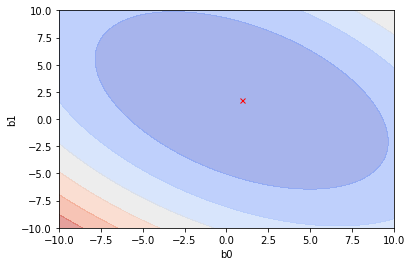

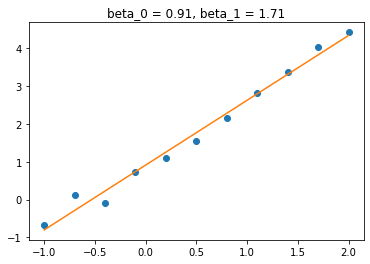

In [11]:
lrl.gridsearch_loss_2D()

Gridsearch minimum:
b0: 0.9109109109109106
Loss function value: 0.039520696360734214


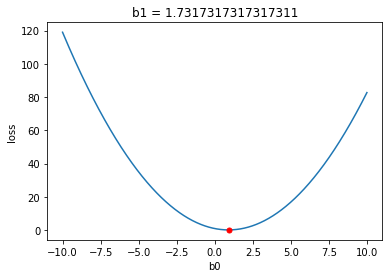

In [12]:
lrl.gridsearch_loss_1D(0, 586)

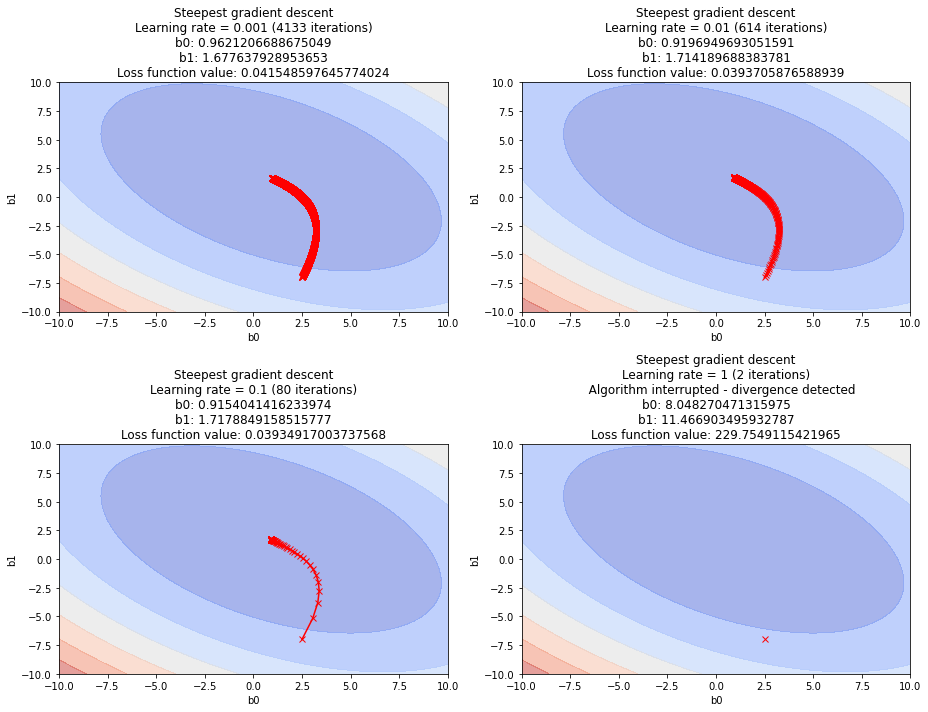

In [13]:
lrl.steepest_gradient_descend_2D(learning_rates = [0.001, 0.01, 0.1, 1], 
                                 initial_p1_index = 2.5, 
                                 initial_p2_index = -7)

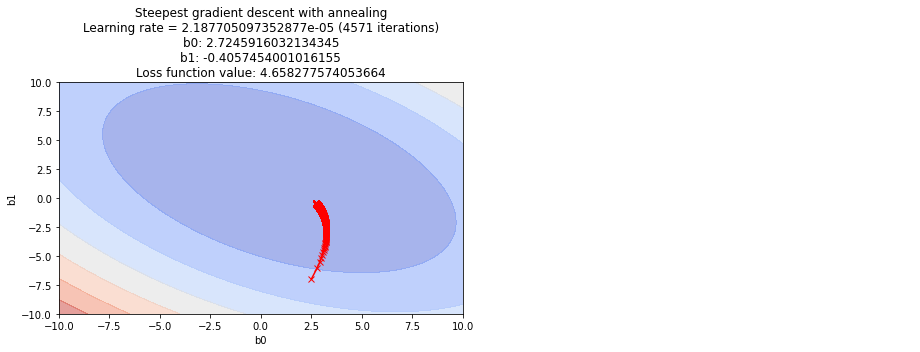

In [14]:
lrl.steepest_gradient_descend_2D(learning_rates = [0.1], 
                                 initial_p1_index = 2.5, 
                                 initial_p2_index = -7, 
                                 method = 'annealing')

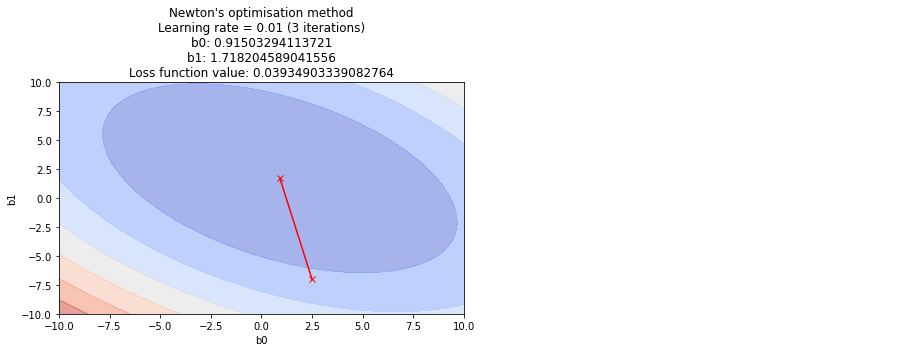

In [15]:
lrl.steepest_gradient_descend_2D(initial_p1_index = 2.5, 
                                 initial_p2_index = -7, 
                                 method = 'newton')

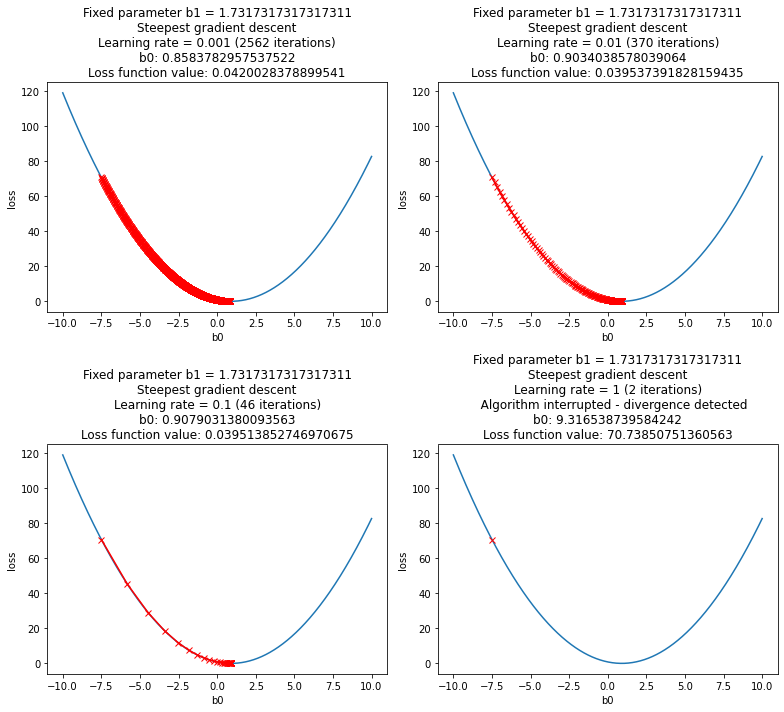

In [16]:
lrl.steepest_gradient_descend_1D(0, 586, -7.5, learning_rates = [0.001, 0.01, 0.1, 1])

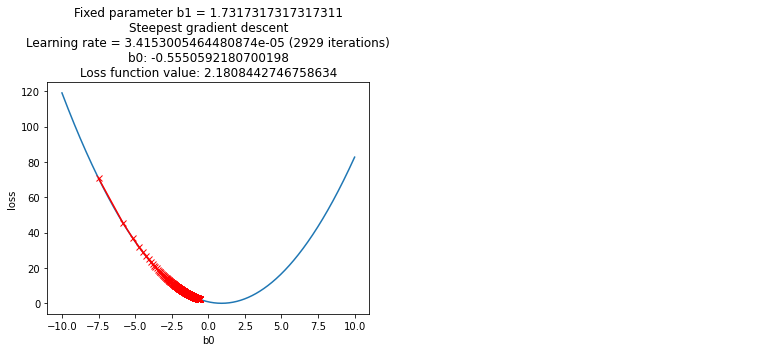

In [17]:
lrl.steepest_gradient_descend_1D(0, 586, -7.5, learning_rates = [0.1], annealing = True)

## Logistic regression

In [18]:
lgl = LogisticRegressionLoss(mu1 = -1,
                             std1 = 2,
                             n1 = 10,
                             mu2 = 1,
                             std2 = 2,
                             n2 = 10,
                             p1lim = [-1.5, 0.9],
                             p2lim = [0, 1.7])

In [19]:
lgl.produce_dataset()

In [20]:
lgl.calculate_loss_2D()

Gridsearch minimum:
b0: -0.25555555555555554
b1: 0.7538538538538538
Loss function value: 10.112244577921873


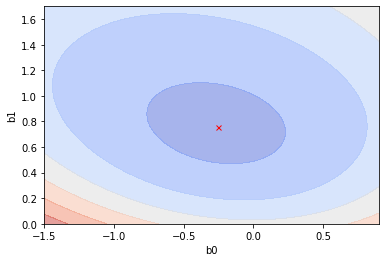

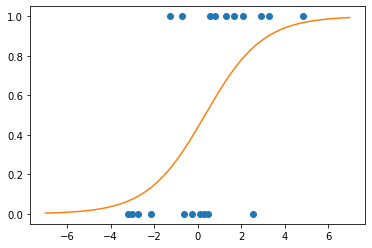

In [21]:
lgl.gridsearch_loss_2D()

Gridsearch minimum:
b0: -0.25555555555555554
Loss function value: 10.112244577921873


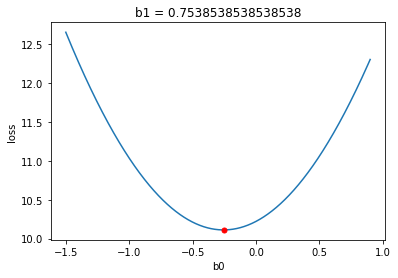

In [22]:
lgl.gridsearch_loss_1D(0, 443)

<ipython-input-6-3d5b83e82390>:63: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.multiply(self.y, np.log(yp)) + np.multiply(1 - self.y, np.log(1 - yp)))
<ipython-input-6-3d5b83e82390>:63: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(np.multiply(self.y, np.log(yp)) + np.multiply(1 - self.y, np.log(1 - yp)))


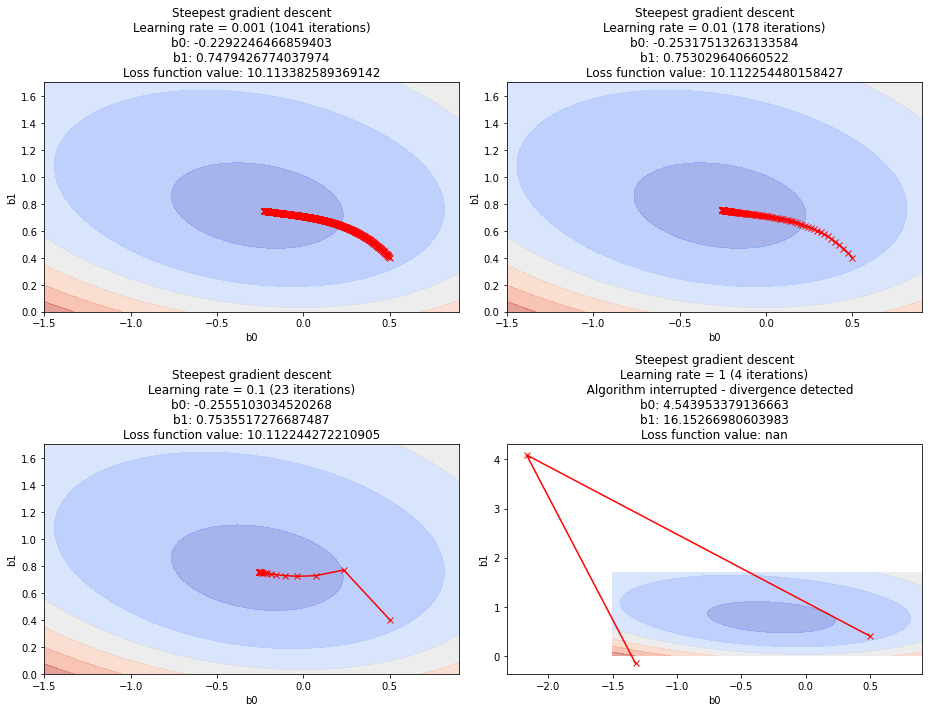

In [23]:
lgl.steepest_gradient_descend_2D(learning_rates = [0.001, 0.01, 0.1, 1], 
                                 initial_p1_index = 0.5, 
                                 initial_p2_index = 0.4)

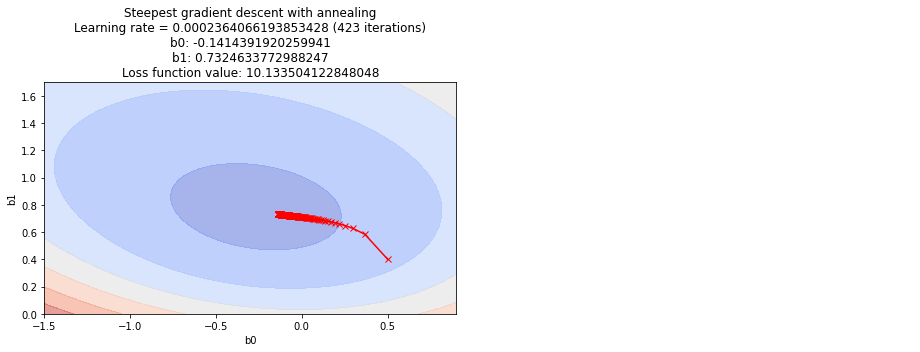

In [24]:
lgl.steepest_gradient_descend_2D(learning_rates = [0.1], 
                                 initial_p1_index = 0.5, 
                                 initial_p2_index = 0.4, 
                                 method = 'annealing')

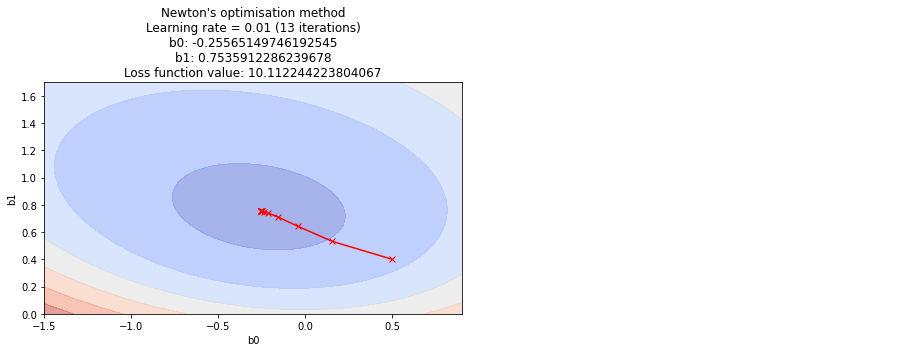

In [25]:
lgl.steepest_gradient_descend_2D(initial_p1_index = 0.5, 
                                 initial_p2_index = 0.4, 
                                 method = 'newton')

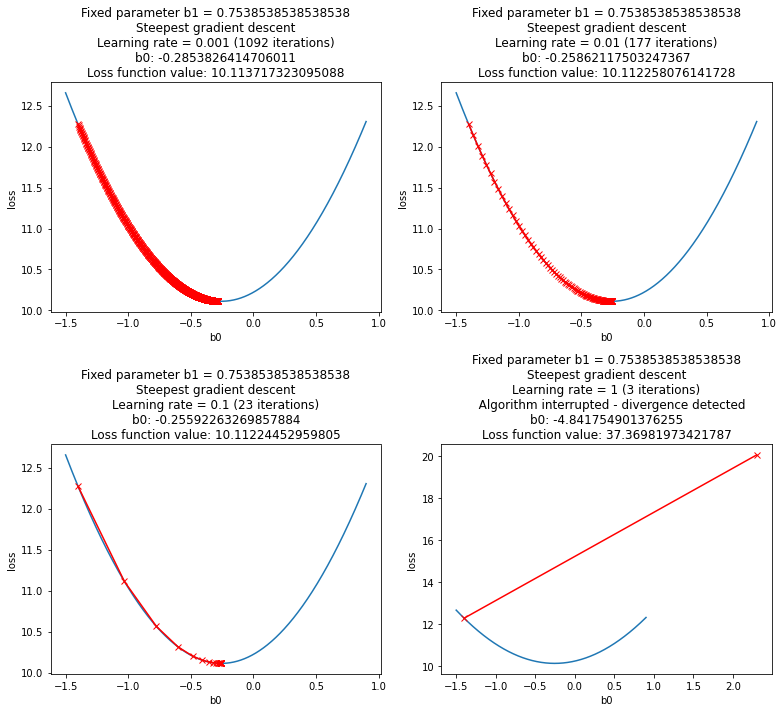

In [26]:
lgl.steepest_gradient_descend_1D(0, 443, -1.4, learning_rates = [0.001, 0.01, 0.1, 1])

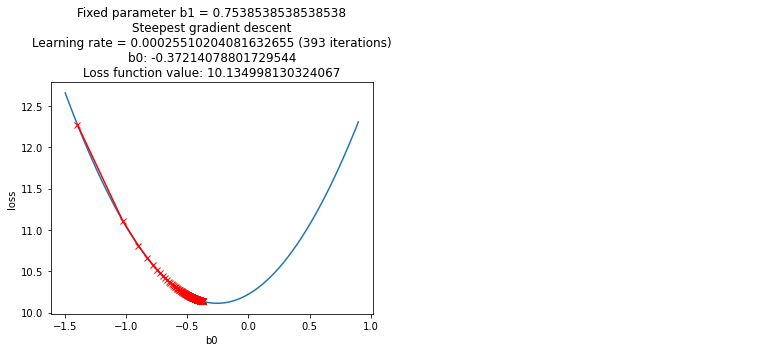

In [27]:
lgl.steepest_gradient_descend_1D(0, 443, -1.4, learning_rates = [0.1], annealing = True)

## Test function (local minima)

Styblinski-Tang function - https://www.sfu.ca/~ssurjano/stybtang.html

Partial derivatives https://es.symbolab.com/solver/partial-derivative-calculator/

Minimum at (-3, -3)

In [28]:
stl = StyblinskiTangLoss(p1lim = [-4, 4], p2lim = [-4, 4])

In [29]:
stl.produce_dataset()

In [30]:
stl.calculate_loss_2D()

Gridsearch minimum:
b1: -2.774774774774775
b2: -3.063063063063063
Loss function value: 1525.6260869929074


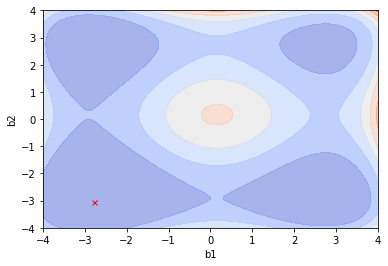

In [31]:
stl.gridsearch_loss_2D()

Gridsearch minimum:
b1: -2.9029029029029028
Loss function value: 54616.383373607074


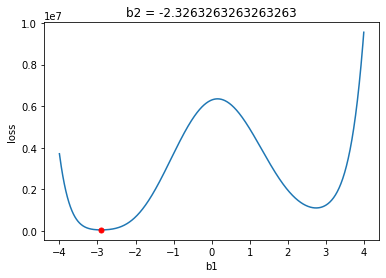

In [32]:
stl.gridsearch_loss_1D(0, 209)

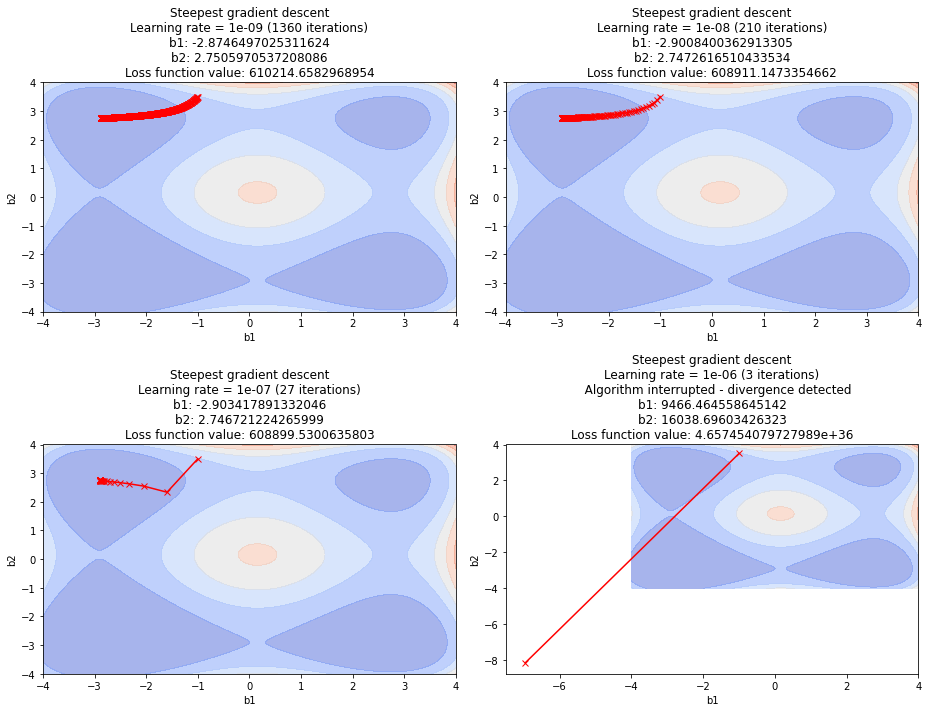

In [33]:
stl.steepest_gradient_descend_2D(learning_rates = [0.000000001, 0.00000001, 0.0000001, 0.000001], 
                                 initial_p1_index = -1, 
                                 initial_p2_index = 3.5)

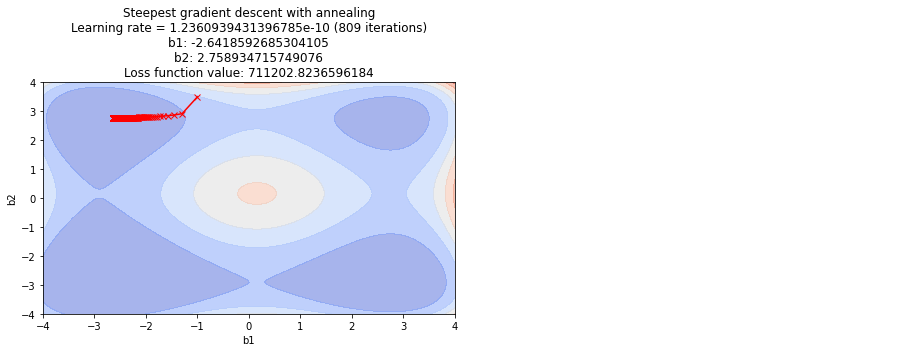

In [34]:
stl.steepest_gradient_descend_2D(learning_rates = [0.0000001], 
                                 initial_p1_index = -1, 
                                 initial_p2_index = 3.5, 
                                 method = 'annealing')

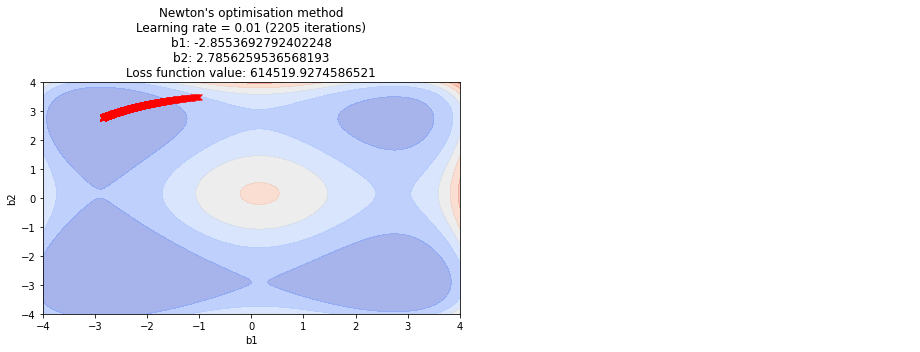

In [35]:
stl.steepest_gradient_descend_2D(initial_p1_index = -1, 
                                 initial_p2_index = 3.5, 
                                 method = 'newton')

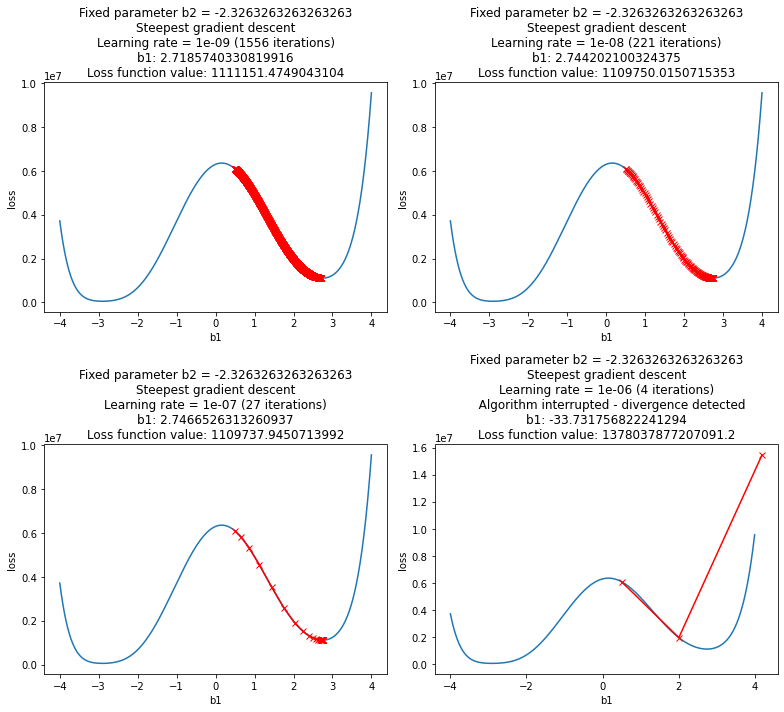

In [36]:
stl.steepest_gradient_descend_1D(0, 209, 0.5, learning_rates = [0.000000001, 0.00000001, 0.0000001, 0.000001])

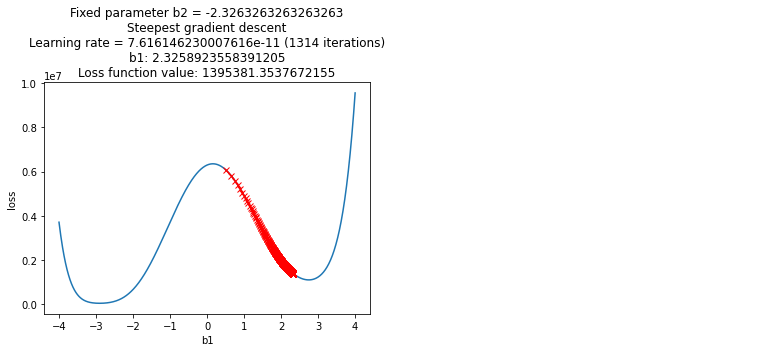

In [37]:
stl.steepest_gradient_descend_1D(0, 209, 0.5, learning_rates = [0.0000001], annealing = True)